In [230]:

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from os.path import join
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
from timeit import timeit
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import logging
logging.basicConfig(filename = "./output.log", filemode = "a", format='%(asctime)s:%(message)s', level=logging.DEBUG, force = True)
from functools import lru_cache
import csv
import seaborn as sns

In [231]:
# This can take a moment
# Please install git large file system before cloning
!git lfs install

!git clone https://github.com/juliettejahan/CapgeminiChallenge.git
!cd CapgeminiChallenge

Updated git hooks.
Git LFS initialized.
fatal: destination path 'CapgeminiChallenge' already exists and is not an empty directory.


In [232]:
ls

CapgeminiChallenge/       Deliverables/  TanguyNotebook.py
data_for_data_challenge/  README.md


In [233]:
import pandas as pd
import os
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error


FILES_FOLDER = {
    "data_for_data_challenge": [
        "data_for_data_challenge/building_data.feather",
        "data_for_data_challenge/meter_data.feather",
        "data_for_data_challenge/weather_data.feather",
        #"data_for_data_challenge/X_test_data.feather", # The dataset test will be released one hour before the end of the Data Challenge
    ]
}


def load_data(folder, data_dir, dict_files=FILES_FOLDER):
    files = dict_files[folder]
    dataframes = []
    print(":: Start loading data")
    for name_file in tqdm(files):
        dataframe = pd.read_feather(os.path.join(data_dir, name_file))
        dataframes.append(dataframe)
    return dataframes


building, meters, weather = load_data("data_for_data_challenge", "./")



:: Start loading data


100%|██████████| 3/3 [00:00<00:00, 11.01it/s]


In [234]:
def process_meters(meter_df):
    meter_df = meter_df.drop(meter_df.loc[meter_df.meter == -1].index).sort_values(by=['timestamp', "building_id"])
    return meter_df
meters = process_meters(meters)


In [235]:
meters.tail(10)
print(meters.meter.unique())

#The site 0 electric meter readings are in kBTU
#count the number of buildings per meter
print("PRINTING METER COUNT")
print(meters.count())
print()
print("PRINTING METER COUNT for meter types 0,..,3")
meters.groupby('meter').count()



[0 3 1 2]
PRINTING METER COUNT
index            976883
building_id      976883
timestamp        976883
meter            976883
meter_reading    976883
dtype: int64

PRINTING METER COUNT for meter types 0,..,3


,index,building_id,timestamp,meter_reading
meter,,,,
0,581842,581842,581842,581842
1,203081,203081,203081,203081
2,135721,135721,135721,135721
3,56239,56239,56239,56239


In [236]:
#plot meters 0,1,2,3 reading bar plots
#sns.barplot(x = meters.meter.loc[meters.meter != 2], y = meters.meter_reading.loc[meters.meter != 2])

Abnormally high readings for meter 2. 
This meter is steam. Different unit? 


10048.511


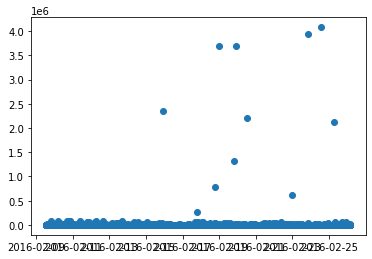

In [237]:
#sort by timestamp and draw meter reading for each time group 
#checking out outliers for meter 2
meter_quick = meters.loc[meters.meter == 2].iloc[10000:13400]
print(meter_quick['meter_reading'].mean())
meter_quick.sort_values(by = "timestamp")
plt.scatter(x =meter_quick.sort_values(by = "timestamp")['timestamp'],y = meter_quick.sort_values(by = "timestamp")['meter_reading'])



The outliers for meter two seem like erroneous readings, we should clamp them or remove them. 
Check out locs 13300 -> 13400.

In [238]:
def remove_meter2_outliers():
    qt2 = meters.groupby('meter').quantile(q = 0.75)
    qt1 = meters.groupby('meter').quantile(q = 0.25)
    qt2_meter2 = qt2.loc[2,"meter_reading"]
    qt1_meter2 = qt1.loc[2,"meter_reading"]
    #iqr based outlier removal
    iqr_meter2 = qt2_meter2 - qt1_meter2
    fence = 3*iqr_meter2
    #remove any not in fency
    #meters = meters.drop(meters.loc[meters.meter == 2 & meters.meter_reading > qt2_meter2 + fence | meters.meter_reading < qt1_meter2 - fence])
    print((meters.shape))
    meters_meter2_outliers = meters.loc[(meters.meter == 2) & ((meters.meter_reading > qt2_meter2 + fence )| (meters.meter_reading < qt1_meter2 - fence))]
    print(meters_meter2_outliers.shape)
    #i am removing 8385 lines from that have bad meter 2 (steam) values
    meters = meters.drop(meters_meter2_outliers.index)
    print(meters.shape)

def remove_meters_outliers(meters):
    qt2 = meters.groupby('meter').quantile(q = 0.75)
    qt1 = meters.groupby('meter').quantile(q = 0.25) #this is a dataframe
    iqr = qt2.meter_reading - qt1.meter_reading #this is a dataframe
    print(iqr)
    print(iqr.loc[2])
    for k in range(0,4):
        print(qt1.loc[k, 'meter_reading'])
        print(f"clipping values lower than {qt1.loc[k, 'meter_reading'] - 2*iqr.loc[k]} and greater than {qt2.loc[k,'meter_reading'] + 2*iqr.loc[k]}")
        filter_meter_k = meters.loc[(meters.meter == k) & ((meters.meter_reading > qt2.loc[k, 'meter_reading'] + 2*iqr.loc[k] ) | (meters.meter_reading <qt1.loc[k, 'meter_reading'] - 2*iqr.loc[k]))]
        meters = meters.drop(filter_meter_k.index)
    return meters



In [239]:
meters2 = remove_meters_outliers(meters)

meter
0     152.350668
1     450.295398
2    1165.055519
3     213.763202
Name: meter_reading, dtype: float64
1165.055519104004
19.55132484436035
clipping values lower than -285.15001106262207 and greater than 476.603328704834
12.027600288391113
clipping values lower than -888.5631952285767 and greater than 1362.9137935638428
67.0999984741211
clipping values lower than -2263.0110397338867 and greater than 3562.266555786133
0.08079999685287476
clipping values lower than -427.44560354948044 and greater than 641.3704053163528


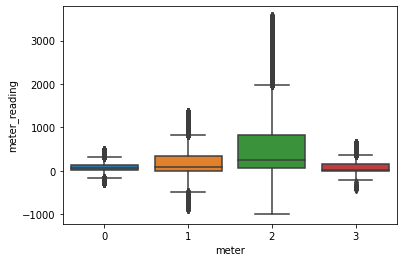

In [240]:
sns.boxplot(x = meters2.meter, y = meters2.meter_reading)

In [241]:
meters.meter.unique()

array([0, 3, 1, 2], dtype=int32)

In [242]:
! git config --list
! git add *
! git status
! git commit -m "added TanguyNoteb"

filter.lfs.smudge=git-lfs smudge -- %f
filter.lfs.process=git-lfs filter-process
filter.lfs.required=true
filter.lfs.clean=git-lfs clean -- %f
core.repositoryformatversion=0
core.filemode=true
core.bare=false
core.logallrefupdates=true
remote.origin.url=https://github.com/juliettejahan/CapgeminiChallenge.git
remote.origin.fetch=+refs/heads/*:refs/remotes/origin/*
branch.main.remote=origin
branch.main.merge=refs/heads/main
hint: You've added another git repository inside your current repository.
hint: Clones of the outer repository will not contain the contents of
hint: the embedded repository and will not know how to obtain it.
hint: If you meant to add a submodule, use:
hint: 
hint: 	git submodule add <url> CapgeminiChallenge
hint: 
hint: If you added this path by mistake, you can remove it from the
hint: index with:
hint: 
hint: 	git rm --cached CapgeminiChallenge
hint: 
hint: See "git help submodule" for more information.
On branch main
Your branch is up to date with 'origin/main'.


In [253]:
import google.colab.drive
google.colab.drive.mount('/content/drive')

def copytoCapG():
    print(os.getcwd())
    filepath="/content/drive/MyDrive/Colab Notebooks/CapgeminiChallengeExplore.ipynb"
    

Mounted at /content/drive


In [255]:
import shutil

def copytoCapG():
    print(os.getcwd())
    src="/content/drive/MyDrive/Colab Notebooks/CapgeminiChallengeExplore.ipynb"
    print(os.listdir("/content"))
    dst = /content/CapgeminiChallenge
    shutil.copyfile(src, dst)


copytoCapG()

/content/CapgeminiChallenge
.
['.config', 'CapgeminiChallenge', '.ipynb_checkpoints', 'drive']
